## 1. 데이터셋 로딩 및 전처리

### 1-1. 데이터셋 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import koreanize_matplotlib
import seaborn as sns
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv('fog_train.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])
test = pd.read_csv('fog_test.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])

### 1-2. 데이터셋 분포 확인

In [4]:
# 클래스별 비율 확인
np.round(
    train['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
-99,0.713%
1,0.249%
2,0.383%
3,0.386%
4,98.269%


In [93]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
1.0,0.251%
2.0,0.386%
3.0,0.389%
4.0,98.975%


In [94]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts().to_frame().reset_index().sort_values('index').set_index('index')
, 3)

,class
index,
1.0,7866
2.0,12088
3.0,12180
4.0,3101809


### 1-3. 전처리

In [3]:
# 지역 처리
train['stn_group'] = train['stn_id'].str[0]
train['stn_group_binary'] = train['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

test['stn_group'] = test['stn_id'].str[0]
test['stn_group_binary'] = test['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

In [4]:
# 안 쓰는 컬럼 drop
# drop_columns = ['year', 'month', 'day', 'time', 'minute'] + ['stn_id', 'stn_group']
drop_columns = ['year', 'minute'] + ['stn_id', 'stn_group']

# train에서 class가 -99인 데이터(결측치) drop
train['class'] = train['class'].replace(-99, np.nan).replace(-99.9, np.nan)
train = train.replace(-99, np.nan).replace(-99.9, np.nan)

train_drop = train.dropna().drop(drop_columns, axis=1).drop('vis1', axis=1).reset_index(drop=True)
test_drop = test.drop(drop_columns, axis=1).drop('class', axis=1).reset_index(drop=True)

train_drop.shape, test_drop.shape

((2994850, 12), (262800, 11))

### 1-4. 과대표집

(일단 생략)

### 1-5. 데이터셋 분리

In [5]:
X_test = test_drop
X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_res_rus, y_res_rus, random_state=42, train_size=0.75, stratify=y_res_rus)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2246137, 11), (748713, 11), (2246137,), (748713,))

---

## 2. EDA

In [6]:
train

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,stn_group,stn_group_binary
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,A,1
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,A,1
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,A,1
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,A,1
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,E,5
3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,E,5
3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,E,5
3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,E,5


In [101]:
train['is_fog'] = train['class'].apply(lambda x: 0 if x >= 4 else 1)
train['is_fog'].value_counts(normalize=True).to_frame()

,is_fog
0,0.982686
1,0.017314


### 2-1. 바람

In [102]:
train['ws10_dir'] = train['ws10_deg'].apply(lambda x: round(x / 90) if pd.notna(x) else np.nan)
train['ws10_dir'].value_counts(sort=False).to_frame()

,ws10_dir
0.0,430131
1.0,714809
2.0,575289
3.0,1095994
4.0,334326


동서남북 방향이니까 0은 4와 같다.

In [103]:
train['ws10_dir'] = train['ws10_dir'].replace(4, 0)
train['ws10_dir'].value_counts(sort=False).to_frame()

,ws10_dir
0.0,764457
1.0,714809
2.0,575289
3.0,1095994


0(북풍), 1(동풍), 2(남풍), 3(서풍)이고 **서풍**의 빈도가 가장 높다.

In [104]:
(np.round(
    train.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100
, 2).astype(str) + '%').rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']]

ws10_dir,동,서,남,북
is_fog,,,,
0,22.65%,34.94%,18.21%,24.2%
1,25.11%,25.86%,20.97%,28.07%


근데 안개 여부에 따라 발라서 보면 조금 달라진다. 평상시엔 서풍이 가장 많지만, 안개가 낀 날에는 **북풍**이 가장 많다.

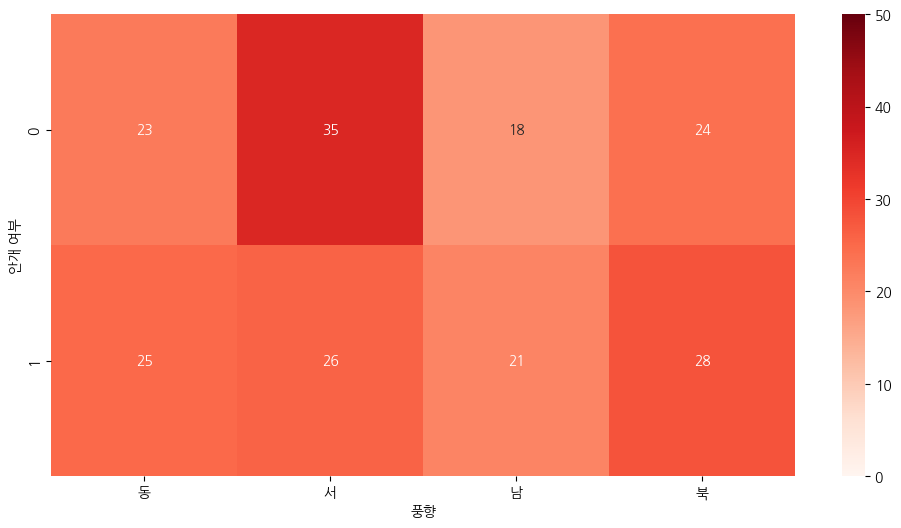

In [105]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    (train.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100)\
    .rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']],
    vmax=50,
    vmin=0,
    cmap='Reds',
    annot=True
)

plt.xlabel('풍향')
plt.ylabel('안개 여부')
plt.xticks()

plt.show()

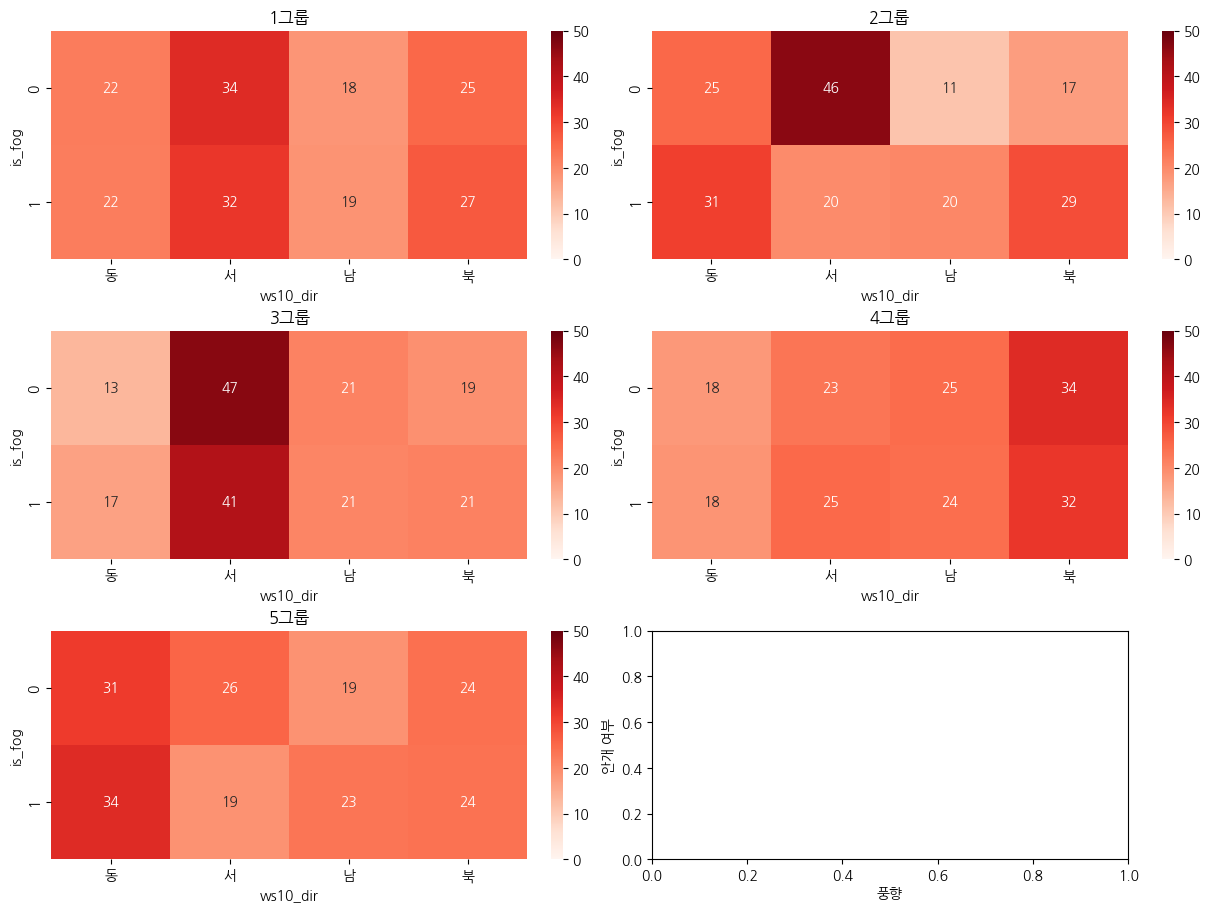

In [106]:
fig, axes = plt.subplots(figsize=(12, 9), ncols=2, nrows=3, constrained_layout=True)

for i, (stn_group_binary, df) in enumerate(train.groupby('stn_group_binary')):
    sns.heatmap(
        (df.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100)\
        .rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']],
        vmax=50,
        vmin=0,
        cmap='Reds',
        annot=True,
        ax=axes[i // 2][i % 2]
    )
    
    axes[i // 2][i % 2].set_title(f'{stn_group_binary}그룹')

plt.xlabel('풍향')
plt.ylabel('안개 여부')

plt.show()

**지역에 따라** 풍향이 다른 영향을 준다.

In [155]:
pd.options.display.float_format = '{:,.3f}'.format

In [156]:
print("=" * 30)
for is_fog, df in train.groupby('is_fog'):
    print("[ 안개가 낀 경우 ]") if is_fog else print("[ 평상시 ]")
    print(df['ws10_ms'].describe())
    print("=" * 30)

[ 평상시 ]
count   3,098,453.000
mean            2.197
std             1.761
min             0.000
25%             0.900
50%             1.800
75%             3.100
max            21.100
Name: ws10_ms, dtype: float64
[ 안개가 낀 경우 ]
count   52,180.000
mean         1.663
std          1.649
min          0.000
25%          0.500
50%          1.200
75%          2.400
max         22.500
Name: ws10_ms, dtype: float64


In [162]:
train[train['is_fog'] == 0]['ws10_ms'].describe()

count   3,098,453.000
mean            2.197
std             1.761
min             0.000
25%             0.900
50%             1.800
75%             3.100
max            21.100
Name: ws10_ms, dtype: float64

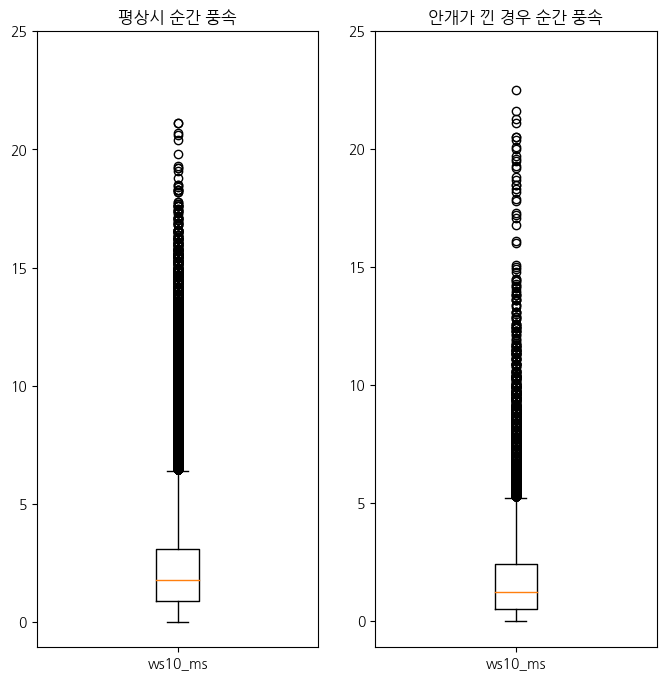

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train[train['is_fog'] == i]['ws10_ms'].dropna(),
        labels=['ws10_ms']
    )
    title = ("안개가 낀 경우" if i else "평상시") + " 순간 풍속"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 26, 5)])

plt.show()

큰 차이는 아니지만 안개가 꼈을 때 순간풍속이 조금 낮은 것 같다.

### 2-2. 기온

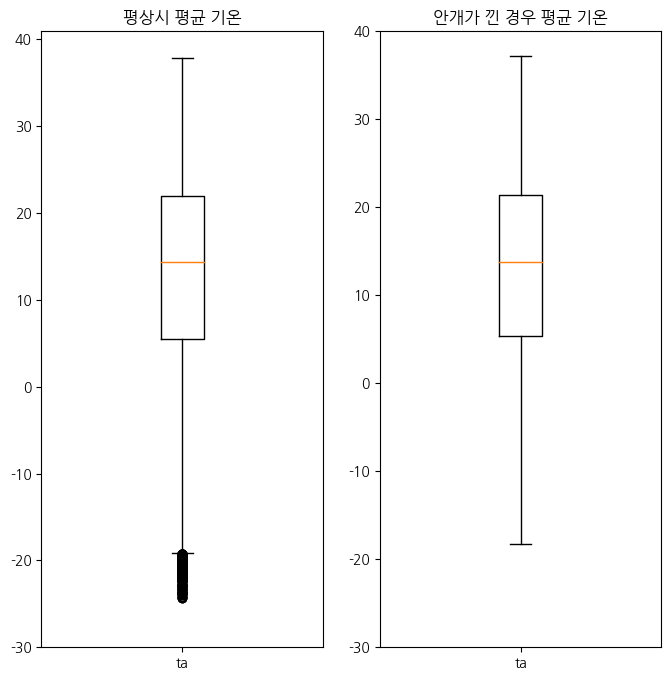

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train[train['is_fog'] == i]['ta'].dropna(),
        labels=['ta']
    )
    title = ("안개가 낀 경우" if i else "평상시") + " 평균 기온"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-30, 41, 10)])

plt.show()

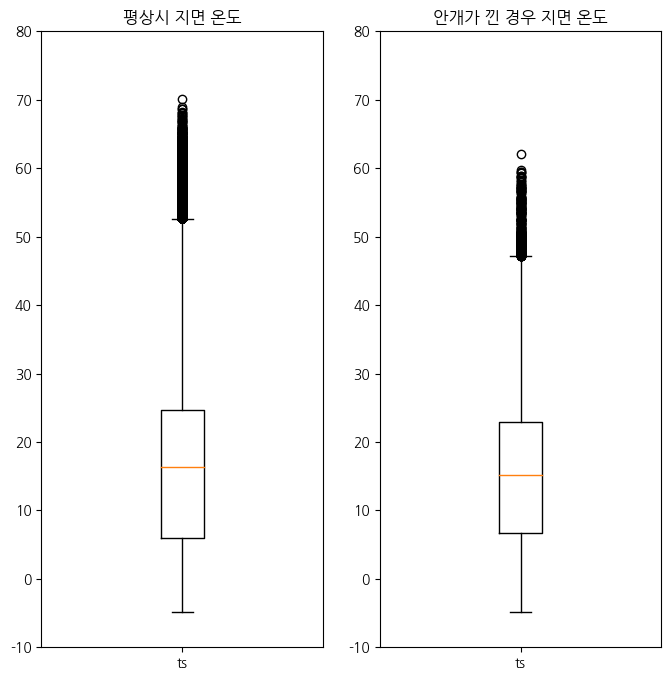

In [110]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train[train['is_fog'] == i]['ts'].dropna(),
        labels=['ts']
    )
    title = ("안개가 낀 경우" if i else "평상시") + " 지면 온도"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-10, 81, 10)])

plt.show()

기온이 높고 지표면이 차가운 경우 안개가 발생하는 경우가 많다. **지면온도와 평균 기온의 차이**를 구해보면 안개 식별에 도움이 되지 않을까?

In [11]:
train['ts-ta'] = train['ts'] - train['ta']

In [185]:
train[train['ts-ta'] == train['ts-ta'].max()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,stn_group,stn_group_binary,is_fog,ws10_dir,ts-ta
2286035,K,6,10,9,10,AD,152.700,1.500,-9.500,0.000,69.300,0.360,33.600,"17,150.000",3.000,A,1,0,2.000,43.100


In [184]:
train[train['ts-ta'] == train['ts-ta'].min()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,stn_group,stn_group_binary,is_fog,ws10_dir,ts-ta
87062,I,8,26,14,30,AB,66.200,3.300,33.700,0.000,55.300,0.250,-3.800,"20,000.000",3.000,A,1,0,1.000,-37.500


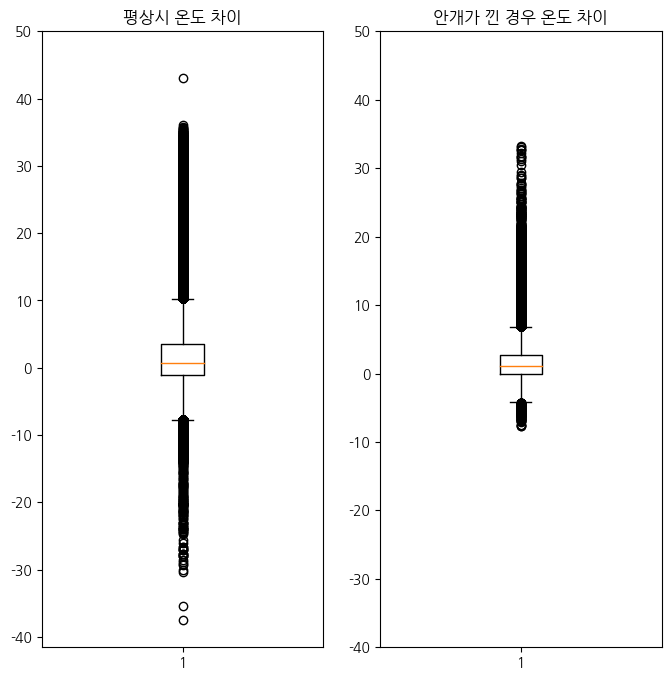

In [111]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train[train['is_fog'] == i]['ts-ta'].dropna()
    )
    title = ("안개가 낀 경우" if i else "평상시") + " 온도 차이"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-40, 51, 10)])

plt.show()

별 차이가 안 느껴진다.

### 2-3. 강수 유무, 상대 습도

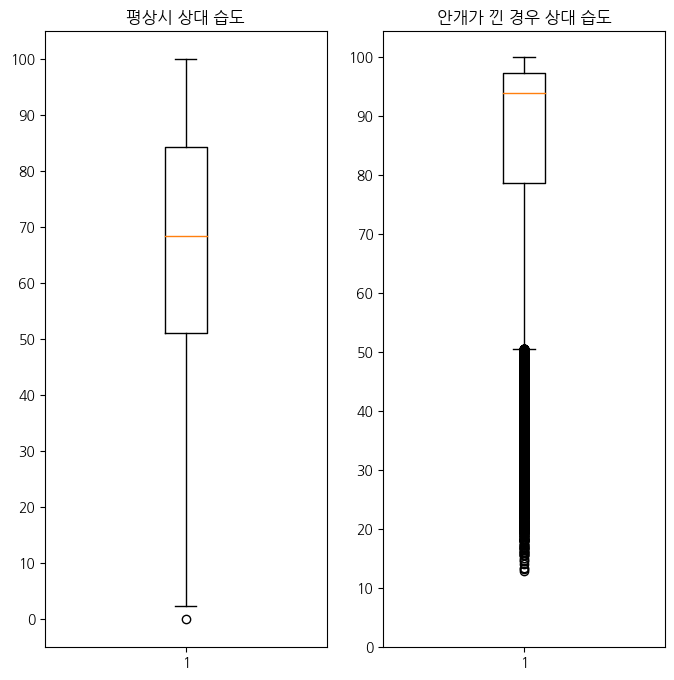

In [112]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train[train['is_fog'] == i]['hm'].dropna()
    )
    title = ("안개가 낀 경우" if i else "평상시") + " 상대 습도"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 101, 10)])

plt.show()

확실히 안개 꼈을 때의 **상대 습도가 높다.**

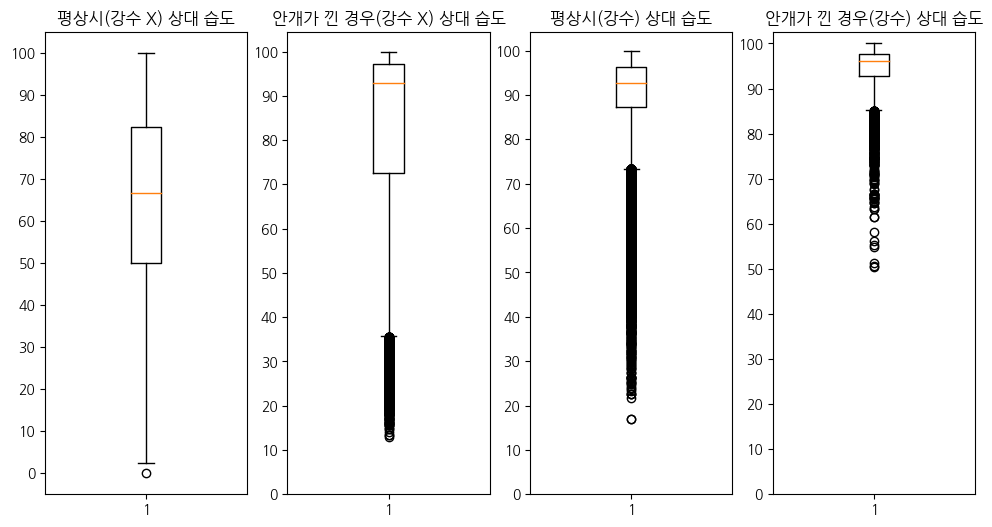

In [113]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 6))

for i in range(2):
    axes[i].boxplot(
        train[(train['is_fog'] == i) & (train['re'] == 0)]['hm'].dropna()
    )
    title = ("안개가 낀 경우(강수 X)" if i else "평상시(강수 X)") + " 상대 습도"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 101, 10)])
    
    axes[i + 2].boxplot(
        train[(train['is_fog'] == i) & (train['re'] == 1)]['hm'].dropna()
    )
    title = ("안개가 낀 경우(강수)" if i else "평상시(강수)") + " 상대 습도"
    axes[i + 2].set_title(title)
    axes[i + 2].set_yticks([j for j in range(0, 101, 10)])
    
plt.show()

상대 습도는 안개 여부보다 **강수 유무**에 더 큰 영향을 받는 것으로 보인다.

### 2-4. datetime 관련

#### 2-4-1. month (season)

In [114]:
fog_by_month = train.groupby('month')['is_fog'].value_counts(normalize=True).to_frame().unstack()
fog_by_month

is_fog          
is_fog         0         1
month                     
1       0.987170  0.012830
2       0.989816  0.010184
3       0.985260  0.014740
4       0.992913  0.007087
5       0.989020  0.010980
6       0.983194  0.016806
7       0.973772  0.026228
8       0.973697  0.026303
9       0.982326  0.017674
10      0.969971  0.030029
11      0.978688  0.021312
12      0.987227  0.012773

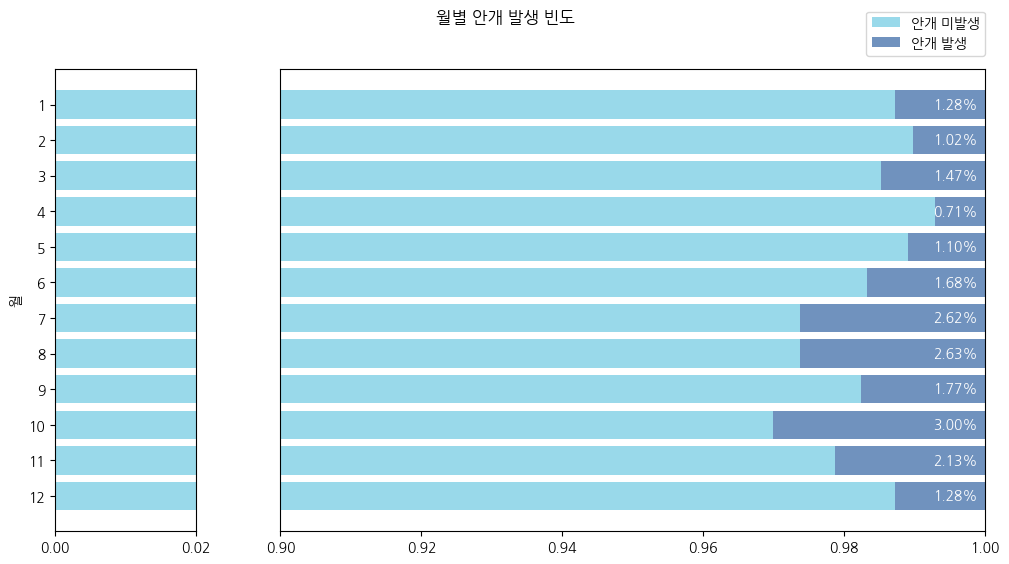

In [115]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])  # 첫 번째 축의 너비는 1, 두 번째 축의 너비는 2

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.barh(fog_by_month.index, fog_by_month['is_fog', 0], color='#99D9EA')
ax1.barh(fog_by_month.index, fog_by_month['is_fog', 1], left=fog_by_month['is_fog', 0], color='#7092BE')
ax1.set_xlim(0, 0.02)
ax1.set_xticks([0.02 * i for i in range(2)])
ax1.set_yticks([i + 1 for i in range(12)])
ax1.invert_yaxis()

ax2.barh(fog_by_month.index, fog_by_month['is_fog', 0], color='#99D9EA')
bars = ax2.barh(fog_by_month.index, fog_by_month['is_fog', 1], left=fog_by_month['is_fog', 0], color='#7092BE')
ax2.set_xlim(0.9, 1)
ax2.set_yticks([])
ax2.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax2.text(
        0.999,
        bar.get_y() + bar.get_height() / 2,
        f'{round(width * 100, 2):.2f}%', 
        ha='right',
        va='center',
        color='white'
    )

fig.suptitle('월별 안개 발생 빈도')
ax1.set_ylabel('월')
ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

여름~가을에 안개가 많이 발생하는 것 같다.

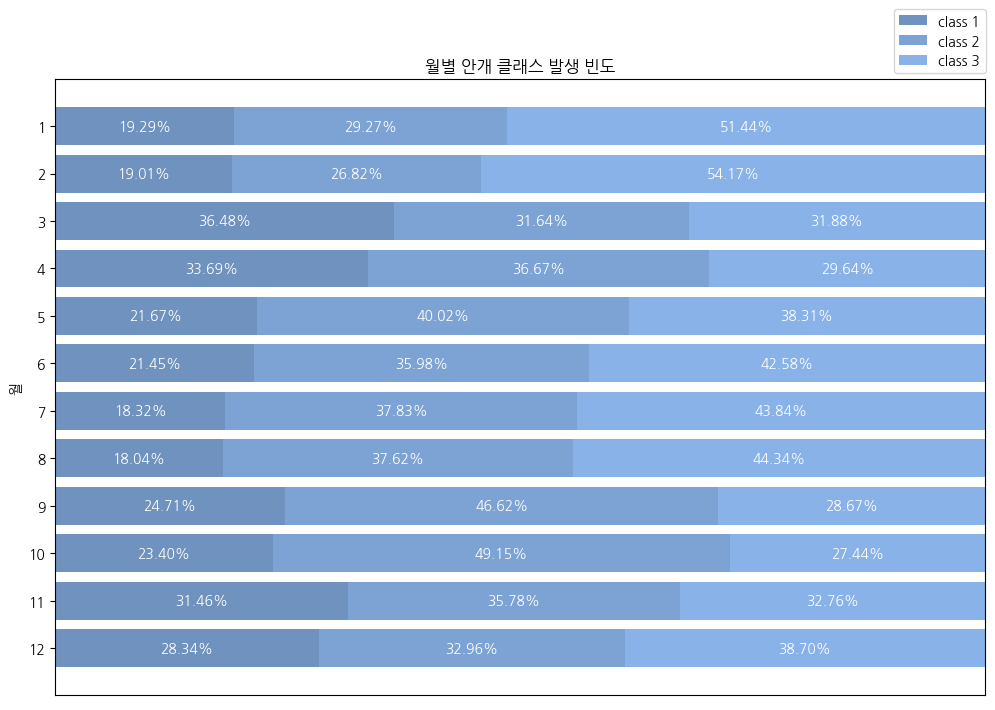

In [166]:
class_by_month = train[train['is_fog'] == 1].groupby(['month'])['class'].value_counts(normalize=True).to_frame().unstack()

plt.figure(figsize=(12, 8))

bars_1 = plt.barh(class_by_month.index, class_by_month['class', 1], color='#7092BE')
bars_2 = plt.barh(class_by_month.index, class_by_month['class', 2], left=class_by_month['class', 1], color='#7DA3D4')
bars_3 = plt.barh(class_by_month.index, class_by_month['class', 3], left=class_by_month['class', 1] + class_by_month['class', 2], color='#89B2E8')
plt.xlim(0, 1)
plt.xticks([])
plt.yticks([i + 1 for i in range(12)])
plt.gca().invert_yaxis()

for i, bars in enumerate([bars_1, bars_2, bars_3]):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            bar.get_x() + width / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='center',
            va='center',
            color='white'
        )

plt.title('월별 안개 클래스 발생 빈도')
plt.ylabel('월')
plt.legend(['class 1', 'class 2', 'class 3'], loc='upper right', bbox_to_anchor=(1.008, 1.125))

plt.show()

**여름, 겨울**에는 **class 1**의 비율이 확연히 줄어드는 것처럼 보인다.

In [116]:
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'fall'
    else:
        return 'winter'

train['season'] = train['month'].apply(get_season)
train.groupby('season')['month'].value_counts(sort=False).to_frame()

month
season month        
fall   9      259200
       10     267840
       11     259199
spring 3      267840
       4      259200
       5      267840
summer 6      259200
       7      267840
       8      267840
winter 1      267820
       2      244800
       12     267840

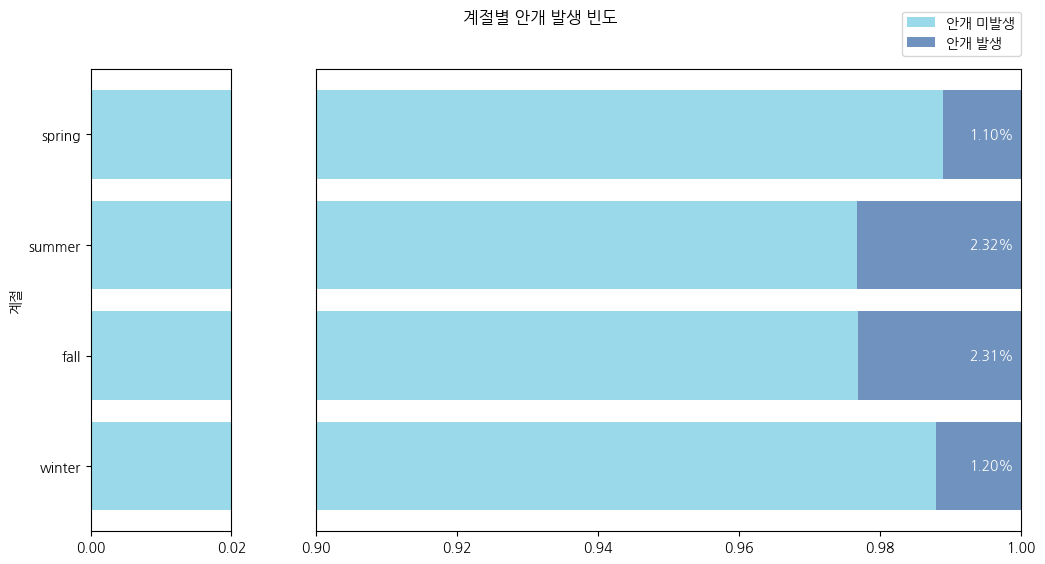

In [117]:
fog_by_season = train.groupby('season')['is_fog'].value_counts(normalize=True).to_frame().unstack().loc[[
    'spring', 'summer', 'fall', 'winter'
]]

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.barh(fog_by_season.index, fog_by_season['is_fog', 0], color='#99D9EA')
ax1.barh(fog_by_season.index, fog_by_season['is_fog', 1], left=fog_by_season['is_fog', 0], color='#7092BE')
ax1.set_xlim(0, 0.02)
ax1.set_xticks([0.02 * i for i in range(2)])
ax1.invert_yaxis()

ax2.barh(fog_by_season.index, fog_by_season['is_fog', 0], color='#99D9EA')
bars = ax2.barh(fog_by_season.index, fog_by_season['is_fog', 1], left=fog_by_season['is_fog', 0], color='#7092BE')
ax2.set_xlim(0.9, 1)
ax2.set_yticks([])
ax2.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax2.text(
        0.999,
        bar.get_y() + bar.get_height() / 2,
        f'{round(width * 100, 2):.2f}%', 
        ha='right',
        va='center',
        color='white'
    )

fig.suptitle('계절별 안개 발생 빈도')
ax1.set_ylabel('계절')
ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

확실히 여름, 가을에 안개가 많이 낀다.

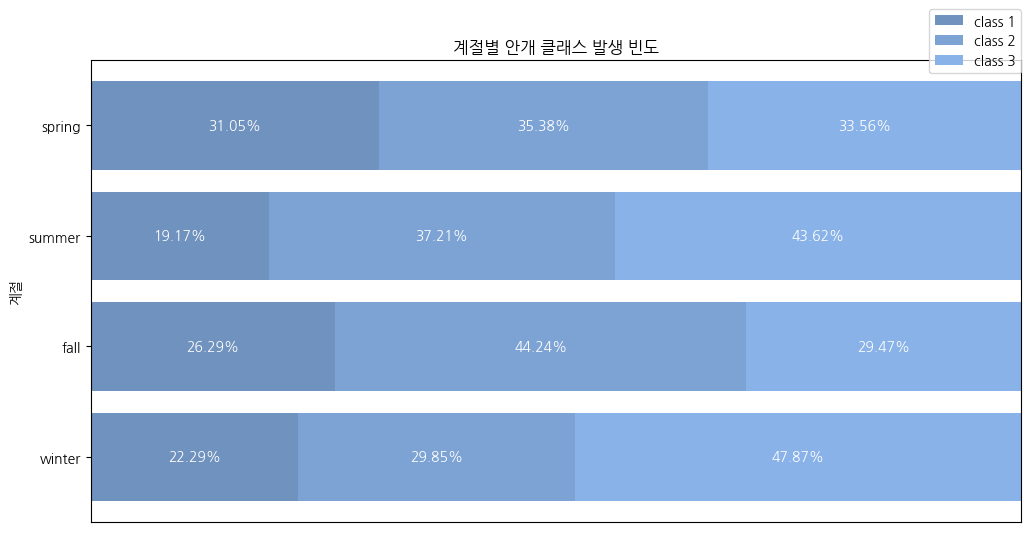

In [169]:
class_by_season = train[train['is_fog'] == 1].groupby(['season'])['class'].value_counts(normalize=True).to_frame().unstack().loc[[
    'spring', 'summer', 'fall', 'winter'
]]

plt.figure(figsize=(12, 6))

bars_1 = plt.barh(class_by_season.index, class_by_season['class', 1], color='#7092BE')
bars_2 = plt.barh(class_by_season.index, class_by_season['class', 2], left=class_by_season['class', 1], color='#7DA3D4')
bars_3 = plt.barh(class_by_season.index, class_by_season['class', 3], left=class_by_season['class', 1] + class_by_season['class', 2], color='#89B2E8')
plt.xlim(0, 1)
plt.xticks([])
plt.gca().invert_yaxis()

for i, bars in enumerate([bars_1, bars_2, bars_3]):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            bar.get_x() + width / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='center',
            va='center',
            color='white'
        )

plt.title('계절별 안개 클래스 발생 빈도')
plt.ylabel('계절')
plt.legend(['class 1', 'class 2', 'class 3'], loc='upper right', bbox_to_anchor=(1.008, 1.125))

plt.show()

아까 살펴본 바와 같이 **여름, 겨울**에는 **class 1**의 비율이 크게 줄어든다.

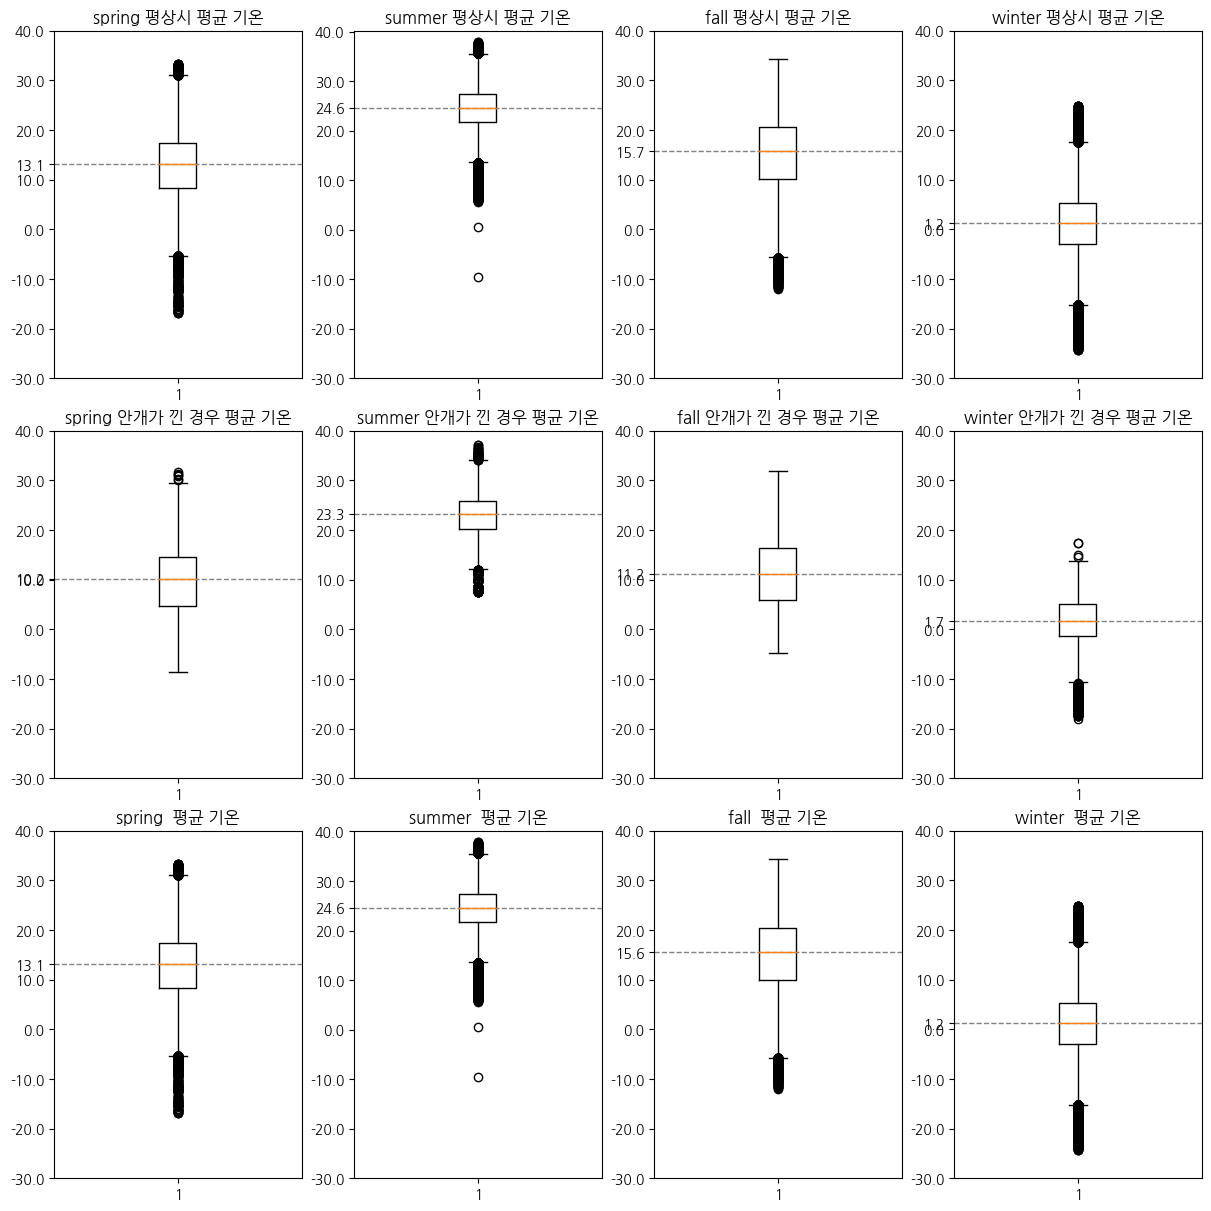

In [66]:
seasons = ['spring', 'summer', 'fall', 'winter']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), constrained_layout=True)

for i in range(3):
    for j, season in enumerate(seasons):
        if i == 2:
            temp_df = train[(train['season'] == season)]['ta'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + " 평균 기온"
        else:
            temp_df = train[(train['season'] == season) & (train['is_fog'] == i)]['ta'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + ("안개가 낀 경우" if i else "평상시") + " 평균 기온"
            
        axes[i][j].axhline(np.median(temp_df), linestyle='--', color='gray', linewidth=1)
        axes[i][j].set_title(title)
        axes[i][j].set_yticks([k for k in range(-30, 41, 10)] + [np.median(temp_df)])
    
plt.show()

전반적으로 **안개 꼈을 때** 평균 기온이 **낮은데**, 겨울의 경우 안개 꼈을 때 평균 기온이 조금 높다.

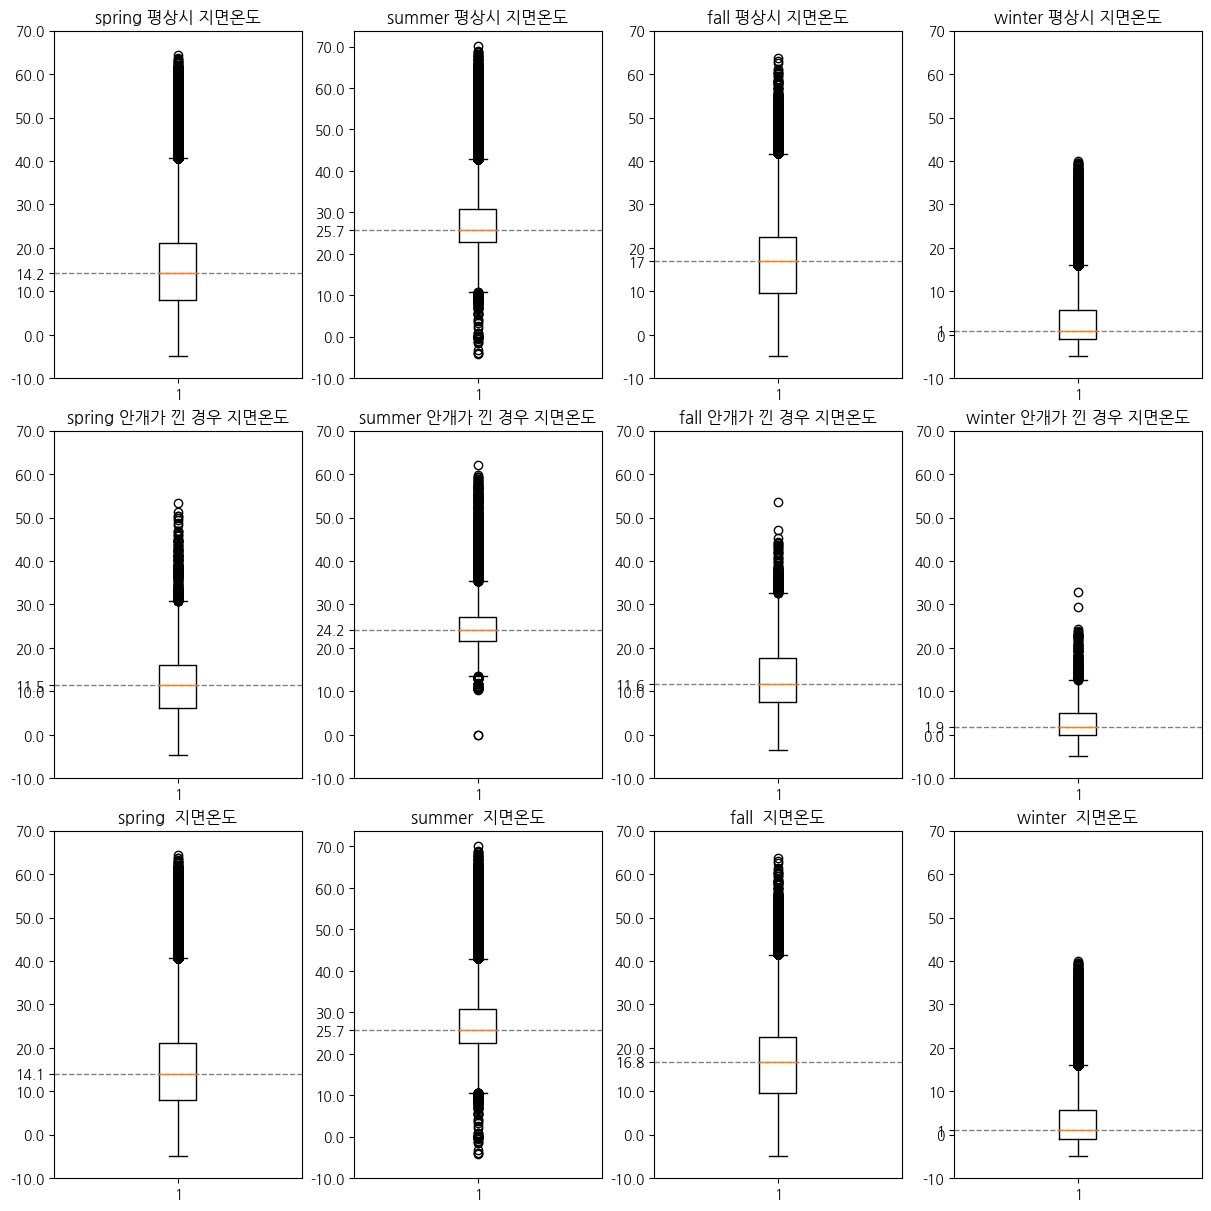

In [55]:
seasons = ['spring', 'summer', 'fall', 'winter']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), constrained_layout=True)

for i in range(3):
    for j, season in enumerate(seasons):
        if i == 2:
            temp_df = train[(train['season'] == season)]['ts'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + " 지면온도"
        else:
            temp_df = train[(train['season'] == season) & (train['is_fog'] == i)]['ts'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + ("안개가 낀 경우" if i else "평상시") + " 지면온도"
            
        axes[i][j].axhline(np.median(temp_df), linestyle='--', color='gray', linewidth=1)
        axes[i][j].set_title(title)
        axes[i][j].set_yticks([k for k in range(-10, 71, 10)] + [np.median(temp_df)])
    
plt.show()

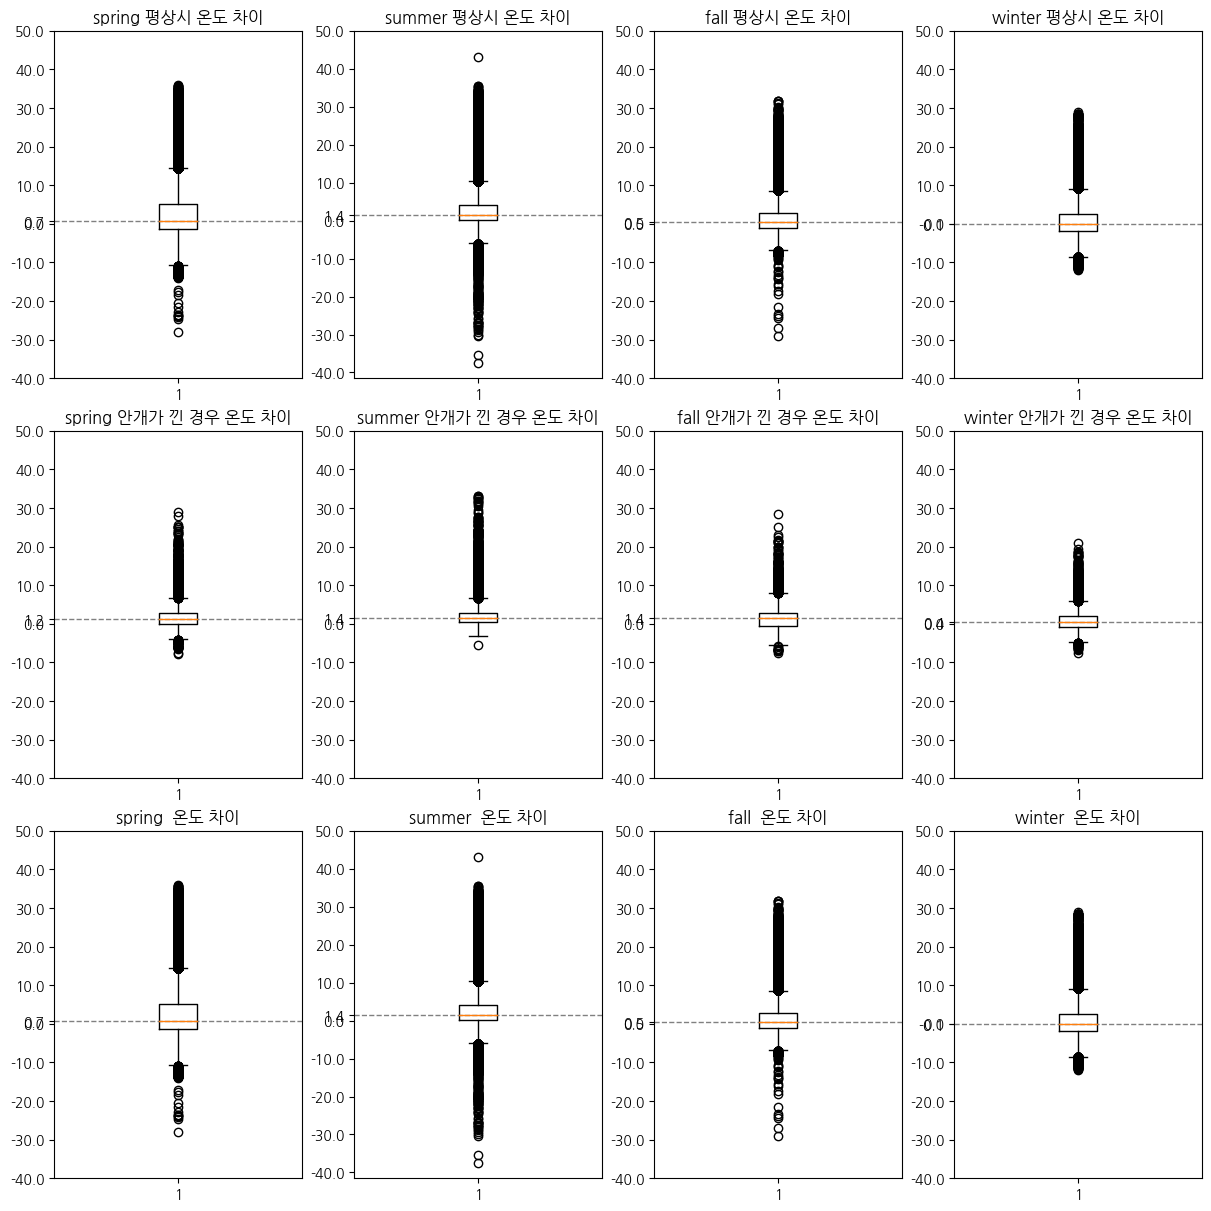

In [68]:
seasons = ['spring', 'summer', 'fall', 'winter']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), constrained_layout=True)

for i in range(3):
    for j, season in enumerate(seasons):
        if i == 2:
            temp_df = train[(train['season'] == season)]['ts-ta'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + " 온도 차이"
        else:
            temp_df = train[(train['season'] == season) & (train['is_fog'] == i)]['ts-ta'].dropna()
            axes[i][j].boxplot(
                temp_df
            )
            title = f"{season} " + ("안개가 낀 경우" if i else "평상시") + " 온도 차이"
            
        axes[i][j].axhline(np.median(temp_df), linestyle='--', color='gray', linewidth=1)
        axes[i][j].set_title(title)
        axes[i][j].set_yticks([k for k in range(-40, 51, 10)] + [np.median(temp_df)])
    
plt.show()

여름, 겨울은 큰 차이 없고, **봄, 가을**은 평균 기온과 지면온도의 차이가 약간 나는 것으로 보인다. 다만 당초 예상대로라면 안개가 꼈을 때 음의 수치를 보여야 하는데 오히려 양의 수치를 보인다.

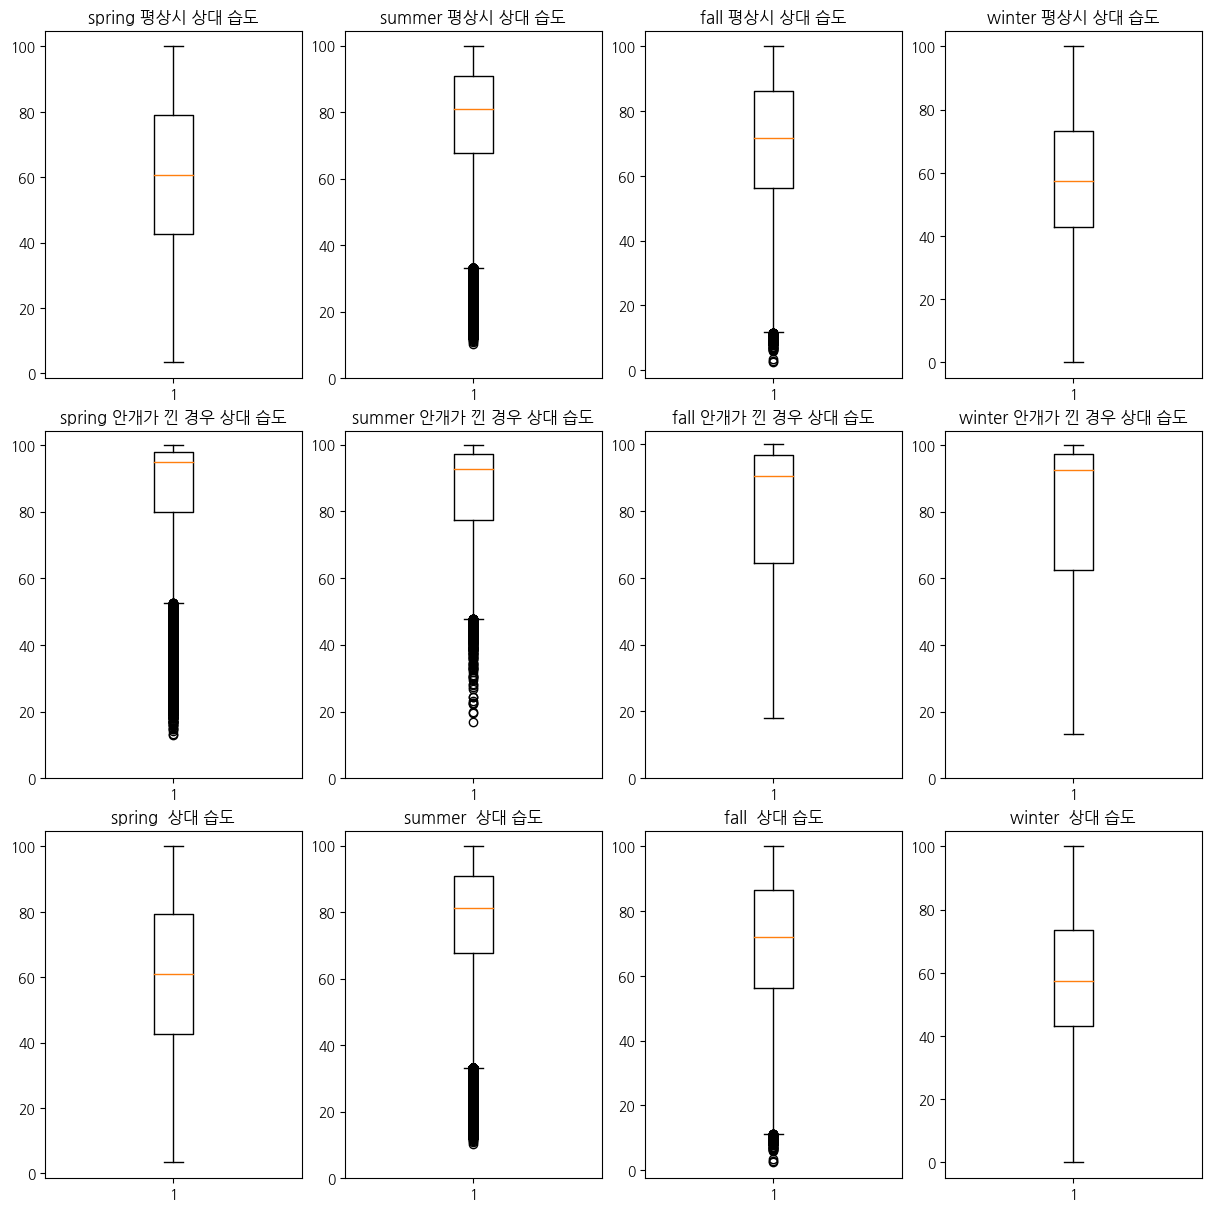

In [73]:
seasons = ['spring', 'summer', 'fall', 'winter']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), constrained_layout=True)

for i in range(3):
    for j, season in enumerate(seasons):
        if i == 2:
            axes[i][j].boxplot(
                train[(train['season'] == season)]['hm'].dropna()
            )
            title = f"{season} " + " 상대 습도"
        else:
            axes[i][j].boxplot(
                train[(train['season'] == season) & (train['is_fog'] == i)]['hm'].dropna()
            )
            title = f"{season} " + ("안개가 낀 경우" if i else "평상시") + " 상대 습도"
            
        axes[i][j].set_title(title)
        axes[i][j].set_yticks([k for k in range(0, 101, 20)])
    
plt.show()

- 평상시의 습도는 여름 > 가을 > 봄 = 겨울이다.
- **봄, 여름**의 안개는 **습도가 높은** 안개이다. 반대로 가을, 겨울의 안개는 습도가 비교적 낮은 안개이다.

#### 2-4-2. time

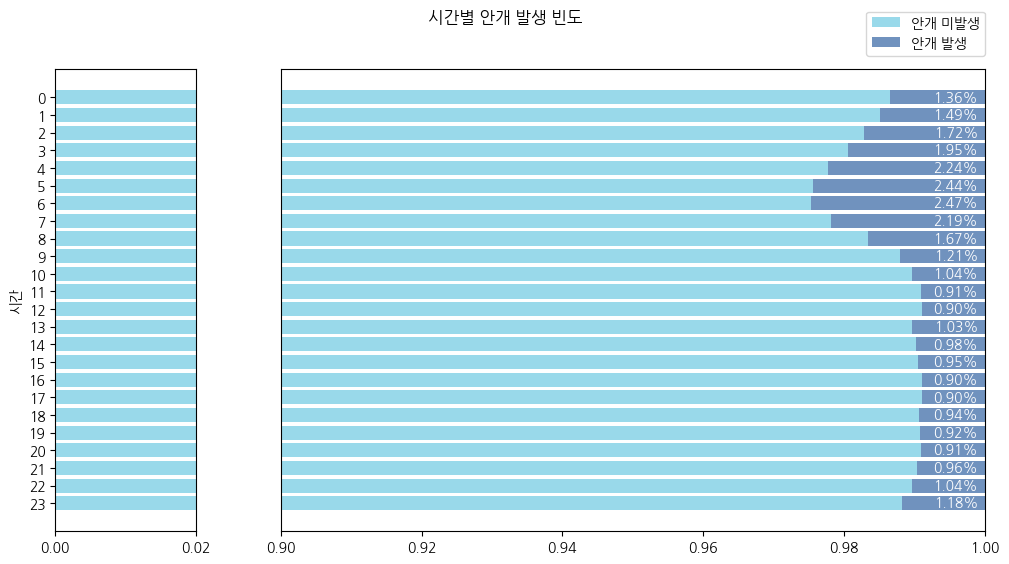

In [81]:
fog_by_time = train.groupby('time')['is_fog'].value_counts(normalize=True).to_frame().unstack()

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])  # 첫 번째 축의 너비는 1, 두 번째 축의 너비는 2

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.barh(fog_by_time.index, fog_by_time['is_fog', 0], color='#99D9EA')
ax1.barh(fog_by_time.index, fog_by_time['is_fog', 1], left=fog_by_time['is_fog', 0], color='#7092BE')
ax1.set_xlim(0, 0.02)
ax1.set_xticks([0.02 * i for i in range(2)])
ax1.set_yticks([i for i in range(24)])
ax1.invert_yaxis()

ax2.barh(fog_by_time.index, fog_by_time['is_fog', 0], color='#99D9EA')
bars = ax2.barh(fog_by_time.index, fog_by_time['is_fog', 1], left=fog_by_time['is_fog', 0], color='#7092BE')
ax2.set_xlim(0.9, 1)
ax2.set_yticks([])
ax2.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax2.text(
        0.999,
        bar.get_y() + bar.get_height() / 2,
        f'{round(width * 100, 2):.2f}%', 
        ha='right',
        va='center',
        color='white'
    )

fig.suptitle('시간별 안개 발생 빈도')
ax1.set_ylabel('시간')
ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

기온이 강하하는 **새벽~아침** 시간대의 안개 발생이 두드러지게 높다.

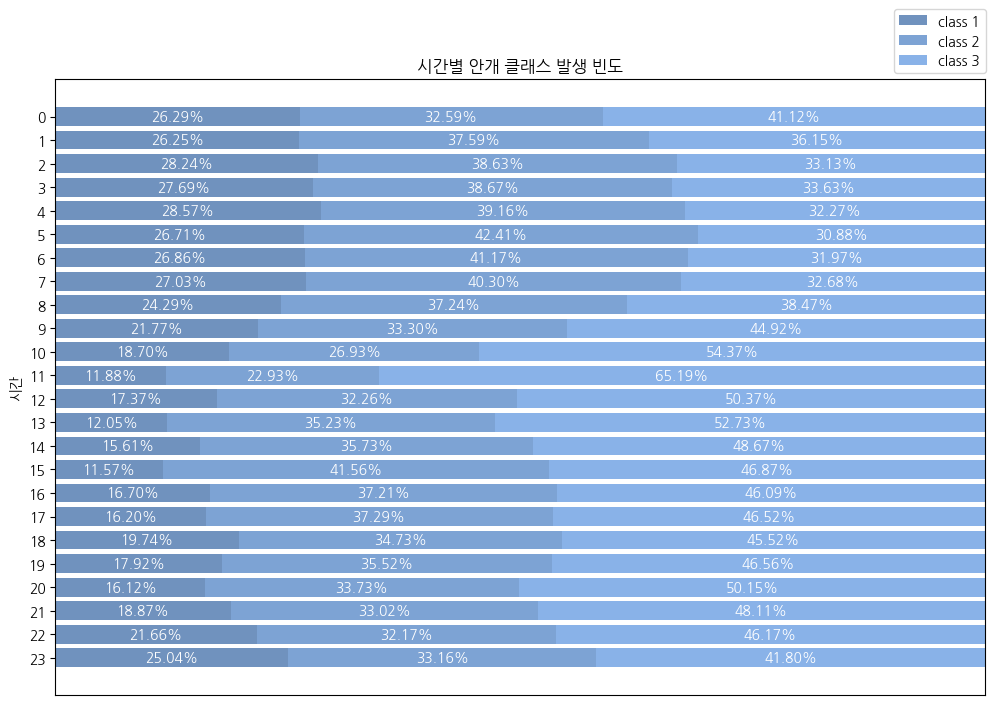

In [174]:
class_by_time = train[train['is_fog'] == 1].groupby(['time'])['class'].value_counts(normalize=True).to_frame().unstack()

plt.figure(figsize=(12, 8))

bars_1 = plt.barh(class_by_time.index, class_by_time['class', 1], color='#7092BE')
bars_2 = plt.barh(class_by_time.index, class_by_time['class', 2], left=class_by_time['class', 1], color='#7DA3D4')
bars_3 = plt.barh(class_by_time.index, class_by_time['class', 3], left=class_by_time['class', 1] + class_by_time['class', 2], color='#89B2E8')
plt.xlim(0, 1)
plt.xticks([])
plt.yticks([i for i in range(24)])
plt.gca().invert_yaxis()

for i, bars in enumerate([bars_1, bars_2, bars_3]):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            bar.get_x() + width / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='center',
            va='center',
            color='white'
        )

plt.title('시간별 안개 클래스 발생 빈도')
plt.ylabel('시간')
plt.legend(['class 1', 'class 2', 'class 3'], loc='upper right', bbox_to_anchor=(1.008, 1.125))

plt.show()

**안개 피크 시간대**에는 **class 1부터 3**까지 고른 분포를 보이고, 이 시간대를 제외하면 **class 3**의 비율이 압도적이다.

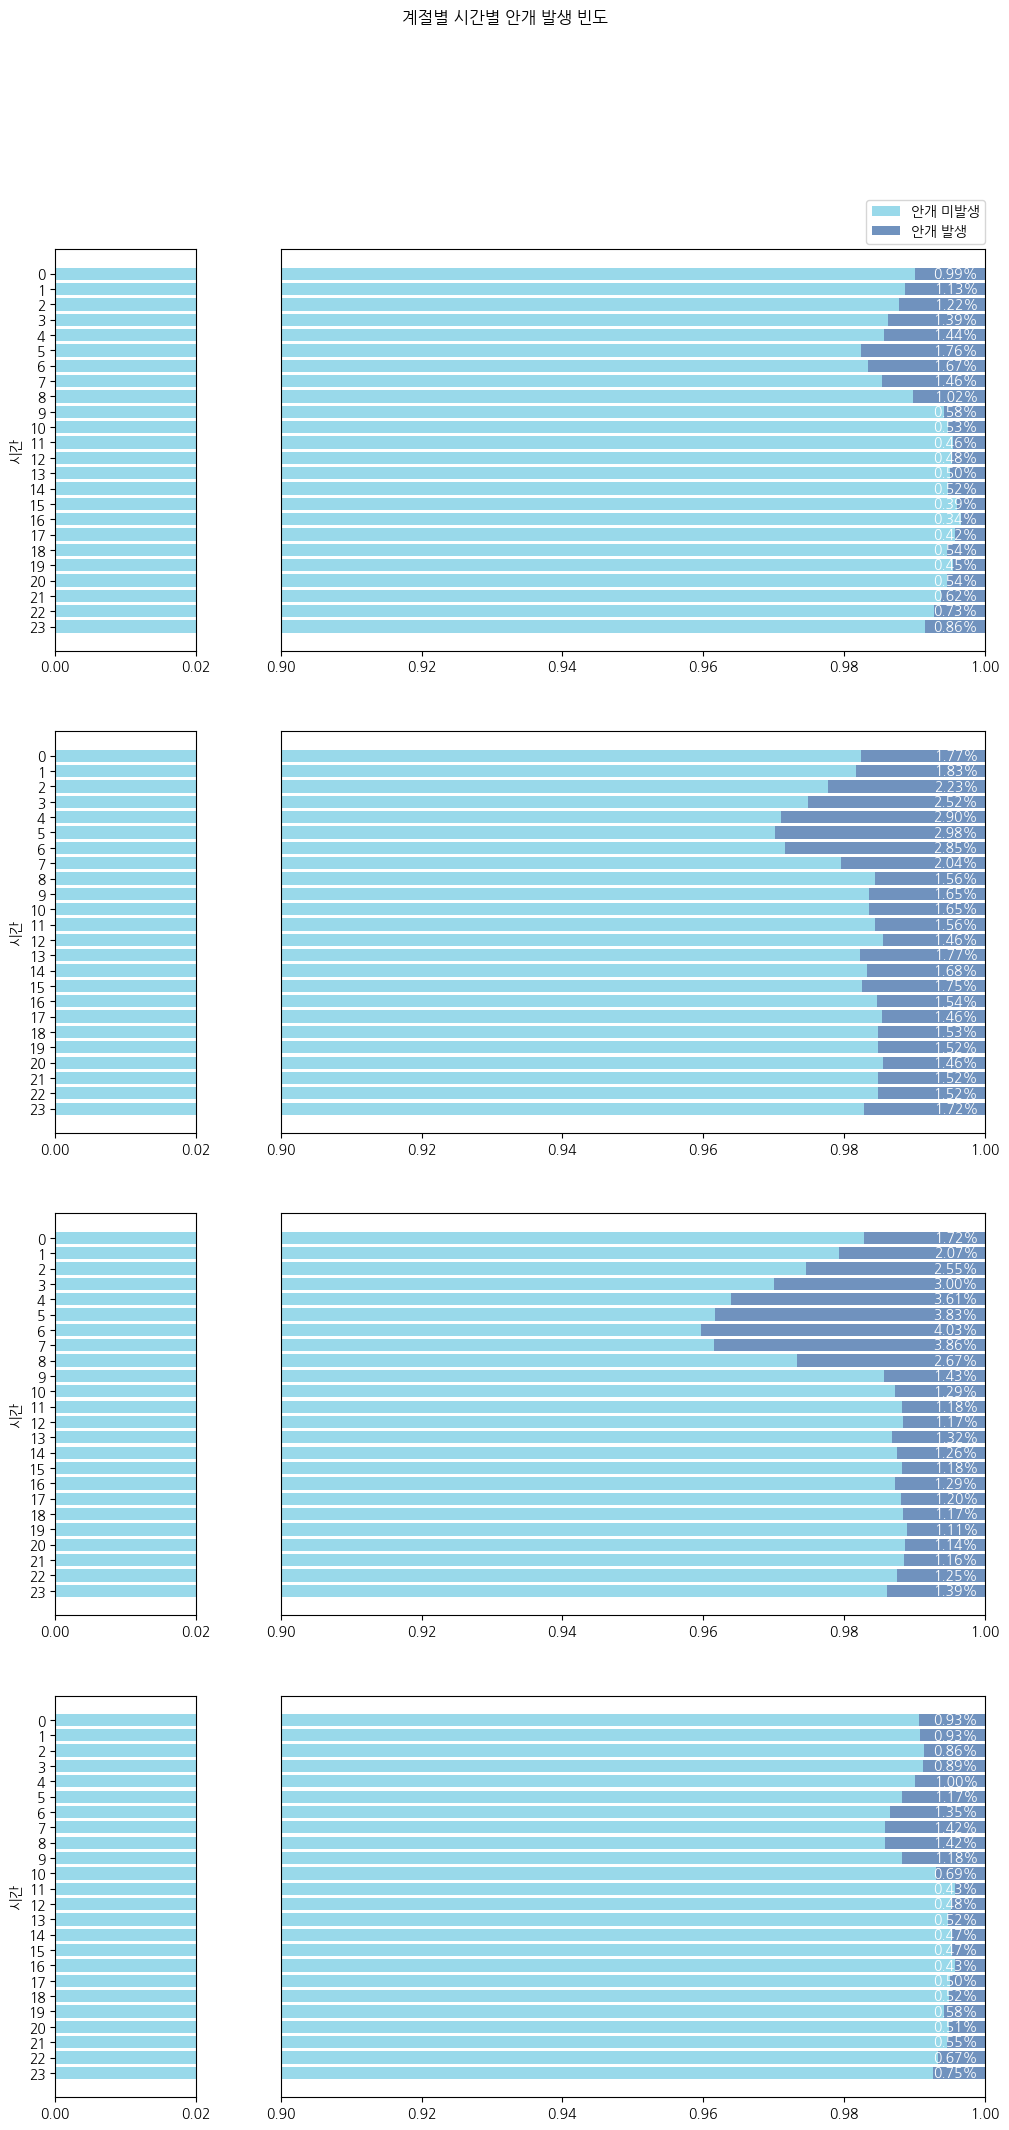

In [89]:
fog_by_time_season = train.groupby(['season', 'time'])['is_fog'].value_counts(normalize=True).to_frame().unstack()\
                        .reset_index().set_index('time')

fig = plt.figure(figsize=(12, 24))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 5])  # 첫 번째 축의 너비는 1, 두 번째 축의 너비는 2

for i, season in enumerate(seasons):
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])

    temp_df = fog_by_time_season[fog_by_time_season['season'] == season]
    ax1.barh(temp_df.index, temp_df['is_fog', 0], color='#99D9EA')
    ax1.barh(temp_df.index, temp_df['is_fog', 1], left=temp_df['is_fog', 0], color='#7092BE')
    ax1.set_xlim(0, 0.02)
    ax1.set_xticks([0.02 * i for i in range(2)])
    ax1.set_yticks([i for i in range(24)])
    ax1.invert_yaxis()

    ax2.barh(temp_df.index, temp_df['is_fog', 0], color='#99D9EA')
    bars = ax2.barh(temp_df.index, temp_df['is_fog', 1], left=temp_df['is_fog', 0], color='#7092BE')
    ax2.set_xlim(0.9, 1)
    ax2.set_yticks([])
    ax2.invert_yaxis()

    for bar in bars:
        width = bar.get_width()
        ax2.text(
            0.999,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='right',
            va='center',
            color='white'
        )

    fig.suptitle(f'계절별 시간별 안개 발생 빈도')
    ax1.set_ylabel('시간')
    None if i else ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

계절별로 일출-일몰 시간이 다르기 때문에 이에 따른 편차가 조금씩 존재한다. 예를 들어 여름에는 **5시**의 안개 발생이 가장 많은데, 겨울에는 **7~8시**가 피크다.

In [91]:
def get_time_range(time):
    if 0 <= time < 3:
        return "range_0"
    elif 3 <= time < 6:
        return "range_1"
    elif 6 <= time < 9:
        return "range_2"
    elif 9 <= time < 12:
        return "range_3"
    elif 12 <= time < 15:
        return "range_4"
    elif 15 <= time < 18:
        return "range_5"
    elif 18 <= time < 21:
        return "range_6"
    else:
        return "range_7"
    
train['time_range'] = train['time'].apply(get_time_range)
train.groupby('time_range')['time'].value_counts(sort=False).to_frame()

time
time_range time        
range_0    0     131500
           1     131520
           2     131520
range_1    3     131520
           4     131520
           5     131520
range_2    6     131520
           7     131520
           8     131520
range_3    9     131520
           10    131520
           11    131520
range_4    12    131520
           13    131520
           14    131520
range_5    15    131520
           16    131520
           17    131520
range_6    18    131519
           19    131520
           20    131520
range_7    21    131520
           22    131520
           23    131520

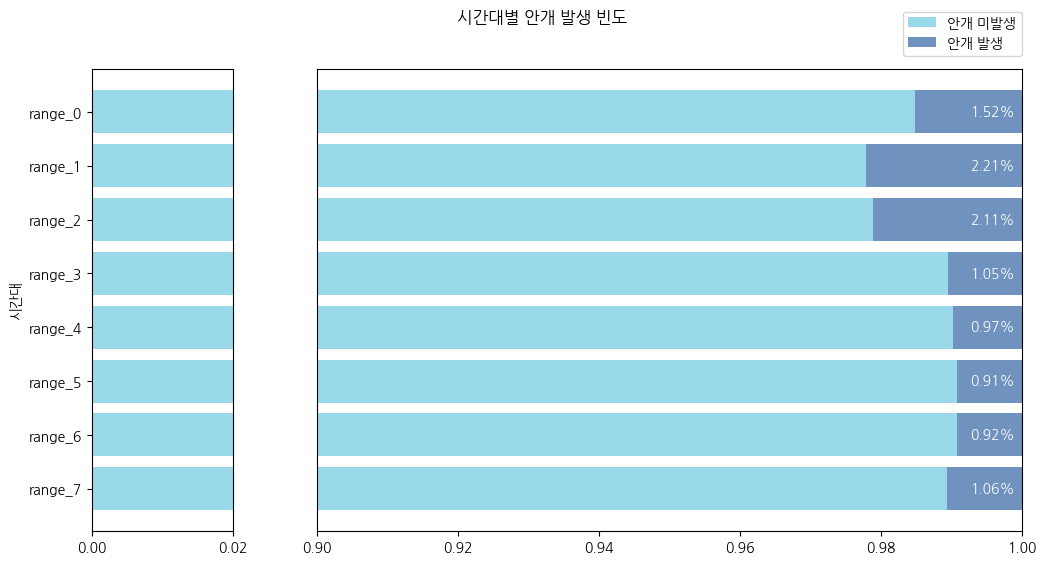

In [92]:
fog_by_range = train.groupby('time_range')['is_fog'].value_counts(normalize=True).to_frame().unstack()

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.barh(fog_by_range.index, fog_by_range['is_fog', 0], color='#99D9EA')
ax1.barh(fog_by_range.index, fog_by_range['is_fog', 1], left=fog_by_range['is_fog', 0], color='#7092BE')
ax1.set_xlim(0, 0.02)
ax1.set_xticks([0.02 * i for i in range(2)])
ax1.invert_yaxis()

ax2.barh(fog_by_range.index, fog_by_range['is_fog', 0], color='#99D9EA')
bars = ax2.barh(fog_by_range.index, fog_by_range['is_fog', 1], left=fog_by_range['is_fog', 0], color='#7092BE')
ax2.set_xlim(0.9, 1)
ax2.set_yticks([])
ax2.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax2.text(
        0.999,
        bar.get_y() + bar.get_height() / 2,
        f'{round(width * 100, 2):.2f}%', 
        ha='right',
        va='center',
        color='white'
    )

fig.suptitle('시간대별 안개 발생 빈도')
ax1.set_ylabel('시간대')
ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

아무래도 앞서 살펴본 바와 같이 **3-5시, 6-8시**의 안개 발생이 가장 많다.

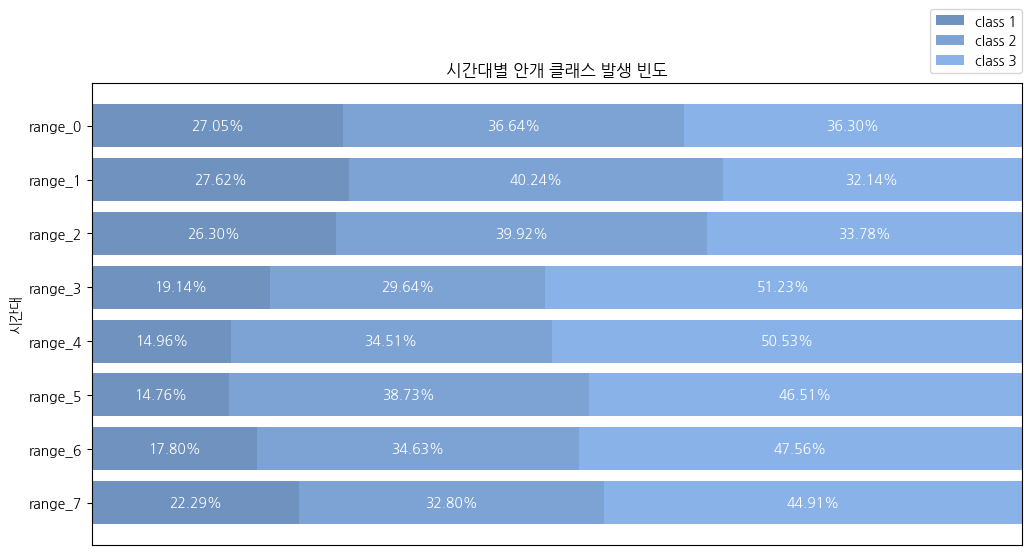

In [182]:
class_by_range = train[train['is_fog'] == 1].groupby(['time_range'])['class'].value_counts(normalize=True).to_frame().unstack()

plt.figure(figsize=(12, 6))

bars_1 = plt.barh(class_by_range.index, class_by_range['class', 1], color='#7092BE')
bars_2 = plt.barh(class_by_range.index, class_by_range['class', 2], left=class_by_range['class', 1], color='#7DA3D4')
bars_3 = plt.barh(class_by_range.index, class_by_range['class', 3], left=class_by_range['class', 1] + class_by_range['class', 2], color='#89B2E8')
plt.xlim(0, 1)
plt.xticks([])
plt.gca().invert_yaxis()

for i, bars in enumerate([bars_1, bars_2, bars_3]):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            bar.get_x() + width / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='center',
            va='center',
            color='white'
        )

plt.title('시간대별 안개 클래스 발생 빈도')
plt.ylabel('시간대')
plt.legend(['class 1', 'class 2', 'class 3'], loc='upper right', bbox_to_anchor=(1.008, 1.175))

plt.show()

오전, 새벽 시간대에는 **고른 class 분포**, 그 외에는 **class 3**의 비율이 높은 점은 기존의 결과와 유사하다.

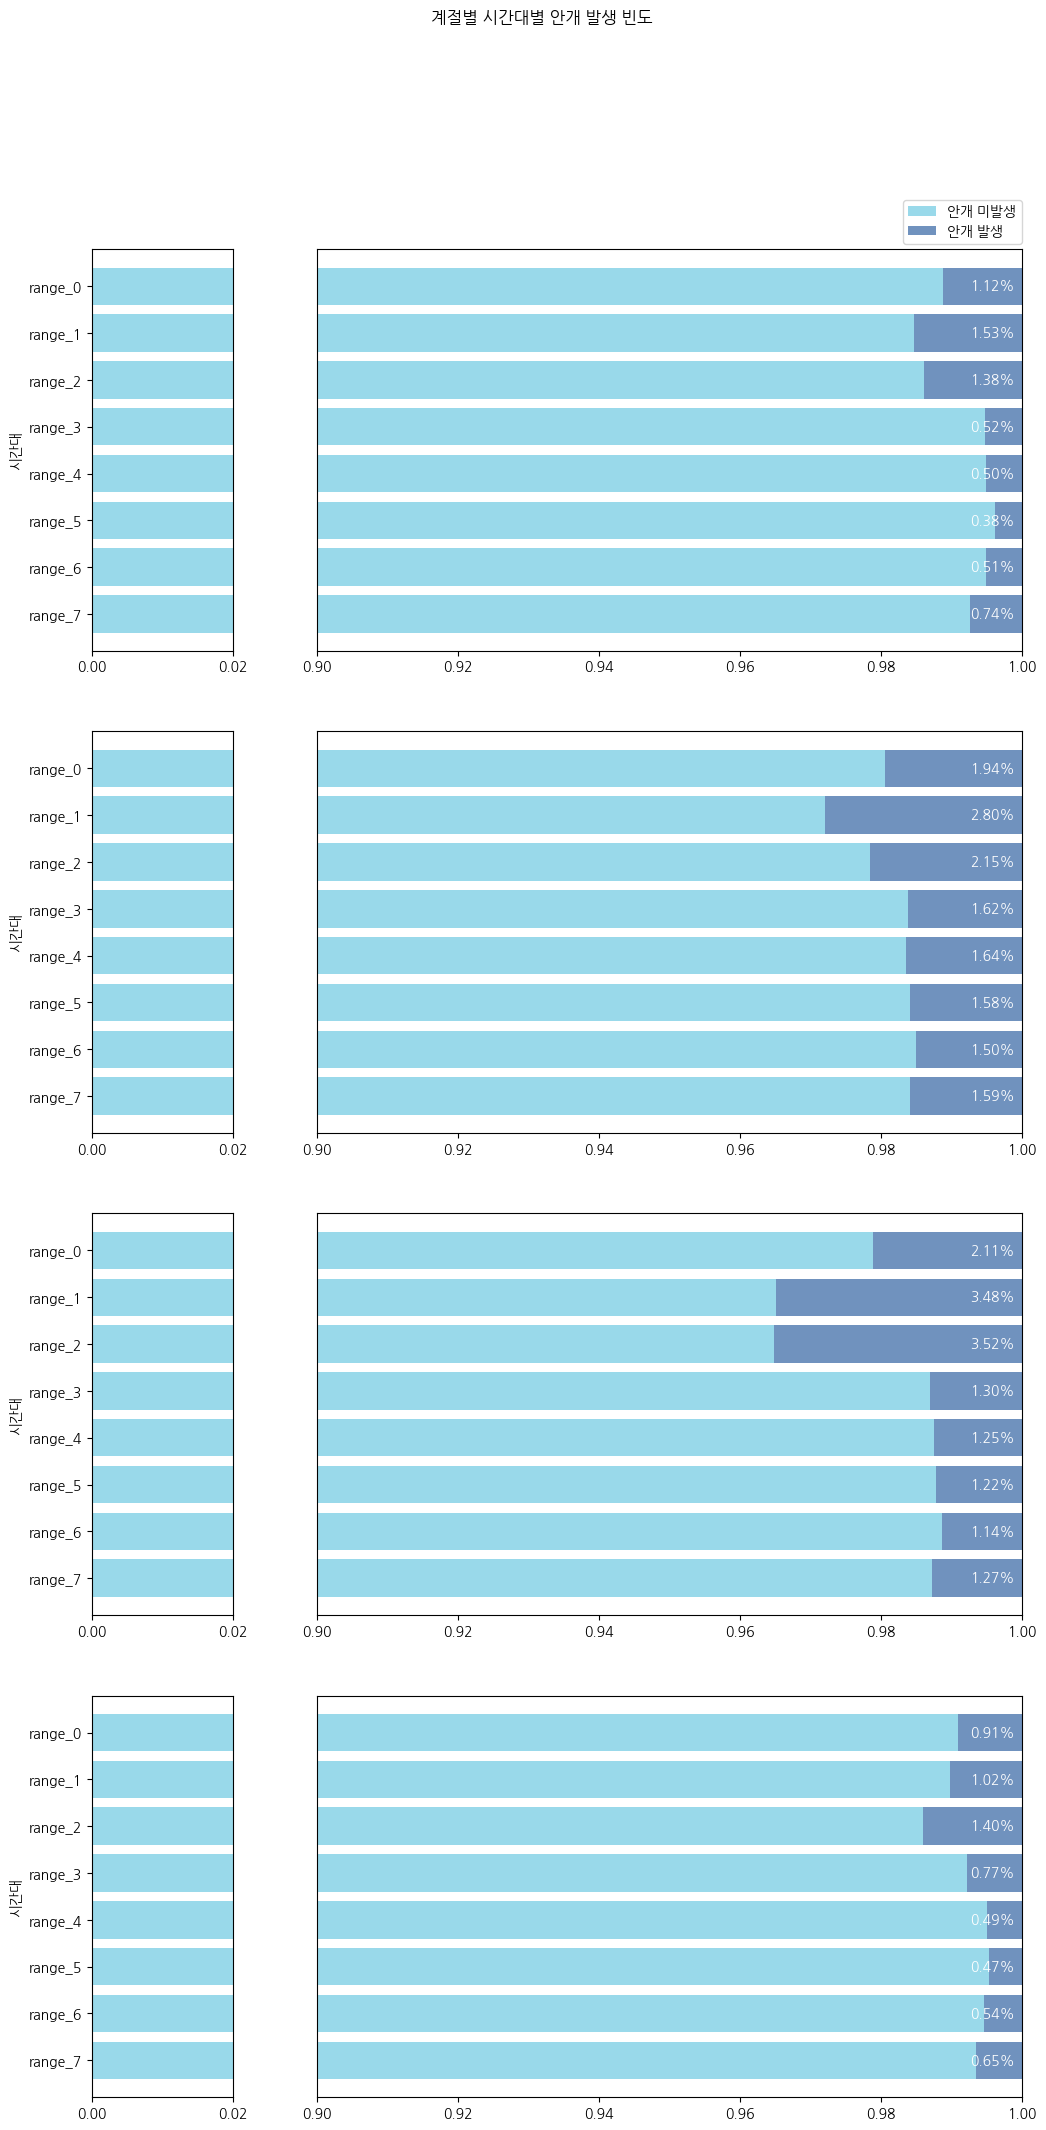

In [94]:
fog_by_range_season = train.groupby(['season', 'time_range'])['is_fog'].value_counts(normalize=True).to_frame().unstack()\
                        .reset_index().set_index('time_range')

fig = plt.figure(figsize=(12, 24))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 5])  # 첫 번째 축의 너비는 1, 두 번째 축의 너비는 2

for i, season in enumerate(seasons):
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])

    temp_df = fog_by_range_season[fog_by_range_season['season'] == season]
    ax1.barh(temp_df.index, temp_df['is_fog', 0], color='#99D9EA')
    ax1.barh(temp_df.index, temp_df['is_fog', 1], left=temp_df['is_fog', 0], color='#7092BE')
    ax1.set_xlim(0, 0.02)
    ax1.set_xticks([0.02 * i for i in range(2)])
    ax1.invert_yaxis()

    ax2.barh(temp_df.index, temp_df['is_fog', 0], color='#99D9EA')
    bars = ax2.barh(temp_df.index, temp_df['is_fog', 1], left=temp_df['is_fog', 0], color='#7092BE')
    ax2.set_xlim(0.9, 1)
    ax2.set_yticks([])
    ax2.invert_yaxis()

    for bar in bars:
        width = bar.get_width()
        ax2.text(
            0.999,
            bar.get_y() + bar.get_height() / 2,
            f'{round(width * 100, 2):.2f}%', 
            ha='right',
            va='center',
            color='white'
        )

    fig.suptitle(f'계절별 시간대별 안개 발생 빈도')
    ax1.set_ylabel('시간대')
    None if i else ax2.legend(['안개 미발생', '안개 발생'], loc='upper right', bbox_to_anchor=(1.01, 1.14))

plt.show()

계절별로 시간대를 유동적으로 줘야 할 필요성이 있어 보이나 이는 추후에 고려하고 우선은 이렇게 진행해 보자.

---

## 3. 모델링

### 3-1. input 변수 선택 및 인코딩

다음의 경우에서 어떤 feature를 투입할지에 대해 고민해 볼 여지가 있다.

- ```month``` vs ```season```
- ```time``` vs ```time_range```

우선은 ```season```, ```time_range```를 이용하기로 한다. 연속형 컬럼을 제외한 범주형 컬럼들은 모두 One-Hot Encoding을 수행해 준다.

In [199]:
for season in seasons:
    train[f'season_{season}'] = train['season'].apply(lambda x: 1 if x == season else 0)

for i in range(8):
    train[f'time_range_{i}'] = train['time_range'].apply(lambda x: 1 if x == f'range_{i}' else 0)

for i in range(5):
    train[f'''stn_{['A', 'B', 'C', 'D', 'E'][i]}'''] = train['stn_group_binary'].apply(
        lambda x: 1 if x == i + 1 else 0
    )

for i in range(4):
    train[f'''ws10_dir_{['N', 'E', 'S', 'W'][i]}'''] = train['ws10_dir'].apply(lambda x: 1 if x == i else 0)
    
train.head()

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,time_range_7,stn_A,stn_B,stn_C,stn_D,stn_E,ws10_dir_N,ws10_dir_E,ws10_dir_S,ws10_dir_W
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,...,0,1,0,0,0,0,1,0,0,0
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,...,0,1,0,0,0,0,1,0,0,0
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,...,0,1,0,0,0,0,1,0,0,0
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,...,0,1,0,0,0,0,1,0,0,0
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,...,0,1,0,0,0,0,0,1,0,0


계절 변수에 대한 One-Hot Encoding을 수행했다.

In [215]:
train_processed = train.dropna().drop([
    'year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'vis1', 'ts-ta', 'season', 'time_range', 'is_fog', 'stn_group',
    'stn_group_binary', 'ws10_dir'
], axis=1)

train_processed.head()

,ws10_ms,ta,re,hm,sun10,ts,class,season_spring,season_summer,season_fall,...,time_range_7,stn_A,stn_B,stn_C,stn_D,stn_E,ws10_dir_N,ws10_dir_E,ws10_dir_S,ws10_dir_W
1,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [216]:
with open('train_processed.pkl', 'wb') as file:
    pickle.dump(train_processed, file)

In [224]:
X = train_processed.drop(['class'], axis=1)
y = pd.Categorical(train_processed['class'] - 1)

X.shape, y.shape

((2994850, 27), (2994850,))

### 3-2. 데이터 스케일링

In [206]:
from sklearn.preprocessing import StandardScaler

In [225]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3-3. 데이터셋 분리

In [226]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2246137, 27), (748713, 27), (2246137,), (748713,))

### 3-4. 베이스라인 모델 생성

In [220]:
from sklearn.metrics import make_scorer

def grid_csi_index(y_true, y_pred):
    
    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] + 
            model_cm[1][0] + model_cm[1][2] + 
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

custom_scorer = make_scorer(grid_csi_index)

In [227]:
models = {
    'XGBoost': XGBClassifier(tree_method='hist', device='cuda', random_state=42),
    'LightGBM': LGBMClassifier(verbosity=-1, device='gpu', random_state=42)
}

model_results = {}
confusion_matrixes = {}
importance = {}

for name, model in models.items():
    start_time = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    csi = grid_csi_index(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    model_results[name] = csi
    confusion_matrixes[name] = confusion_matrix(y_val, y_pred)
#     if name == 'XGBoost':
#         importance[name] = model.get_score(importance_type='weight')
#         continue
#     elif name == 'LightGBM':
#         importance[name] = model.feature_importance(importance_type='split')
    time_delta = datetime.now() - start_time
    with open(f'''{name}(튜닝X)_{start_time.strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
        pickle.dump(model, file)
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, 정확도: {np.round(accuracy, 5)}, F1: {np.round(f1, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
    print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost 학습 완료! CSI: 0.07469, Accuracy: 0.99002, Recall: 0.99002, Precision: 0.98632, 학습 시간: 10.42s
LightGBM 학습 완료! CSI: 0.0628, Accuracy: 0.98812, Recall: 0.98812, Precision: 0.98264, 학습 시간: 13.57s


기존 대비 2배 정도 성능 높게 나오는 점 확인했는데 아무래도 이 두 모델은 안 될 듯하다.

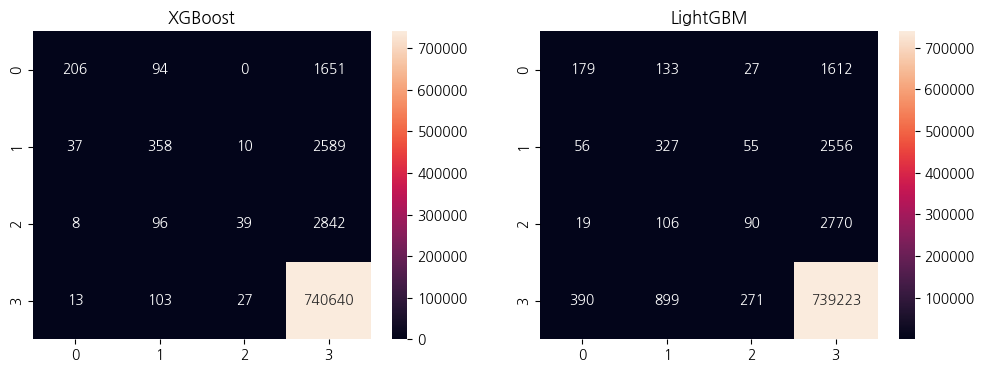

In [228]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.heatmap(
    pd.DataFrame(confusion_matrixes['XGBoost']),
    annot=True,
#     vmax=1000,
    fmt=".0f",
    ax=axes[0]
)
axes[0].set_title('XGBoost')

sns.heatmap(
    pd.DataFrame(confusion_matrixes['LightGBM']),
    annot=True,
#     vmax=1000,
    fmt=".0f",
    ax=axes[1]
)
axes[1].set_title('LightGBM')

plt.show()

성능에 큰 차이 없이 두 모델 모두 비슷하게 예측하는 점 확인 가능했다.

### 2-2. 하이퍼파라미터 튜닝

In [29]:
xgb = XGBClassifier(tree_method='hist', device='cuda', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=custom_scorer, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy: 0.5492423328348598


In [30]:
best_model = grid_search.best_estimator_

In [32]:
with open(f'''XGBoost_{datetime.now().strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
    pickle.dump(best_model, file)

### 2-3. 결과 확인

In [33]:
y_pred = best_model.predict(X_val)
csi = grid_csi_index(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}")

CSI: 0.5605, Accuracy: 0.65319, Recall: 0.65319, Precision: 0.65311


In [36]:
y_pred = best_model.predict(X_test)
X_test['class'] = y_pred

In [40]:
np.round(
    X_test['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
0,3.881%
1,6.755%
2,8.927%
3,80.438%


In [11]:
with open('XGBoost_20240610190208.pkl', 'rb') as file:
    best_model = pickle.load(file)

---

## 3. 결과

In [22]:
# 베이스라인 모델

X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
xgb = XGBClassifier(tree_method='hist', device='cuda', random_state=42)

# rus = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
csi = grid_csi_index(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}")

CSI: 0.05164, Accuracy: 0.99016, Recall: 0.99016, Precision: 0.98676


In [19]:
# Under-Sampling + 튜닝 된 버전

X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
xgb = XGBClassifier(tree_method='hist', device='cuda', random_state=42,
                    colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, ubsample=0.8)

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

xgb.fit(X_train_res, y_train_res)
y_pred = xgb.predict(X_val)
csi = grid_csi_index(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}")

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\xgboost\core.py:160: UserWarning: [20:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "ubsample" } are not used.

  warnings.warn(smsg, UserWarning)


CSI: 0.036, Accuracy: 0.84286, Recall: 0.84286, Precision: 0.98951


In [20]:
# 튜닝 된 버전

X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
xgb = XGBClassifier(tree_method='hist', device='cuda', random_state=42,
                    colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, ubsample=0.8)

# rus = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
csi = grid_csi_index(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}")

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\xgboost\core.py:160: UserWarning: [20:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "ubsample" } are not used.

  warnings.warn(smsg, UserWarning)


CSI: 0.06541, Accuracy: 0.99028, Recall: 0.99028, Precision: 0.987
